<a href="https://colab.research.google.com/github/ccc-frankfurt/Practical_ML_WS19/blob/master/week12/q_learning_Taxi_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on coursera's Practical RL course by National Research University Higher School of Economics, https://www.coursera.org/learn/practical-rl/home/welcome

We will make a Q-Learning agent to solve OpenAI Gym's Taxi problem.

Q-Learning update equation:


*   tabular: $$ Q(s,a) := (1 - \alpha) \cdot Q(s,a) + \alpha \cdot (r(s,a) + \gamma \cdot V(s')) \\ = Q(s,a) + \alpha \cdot (r(s,a) + \gamma \cdot V(s') - Q(s,a))$$

For more definitions, see also https://towardsdatascience.com/the-complete-reinforcement-learning-dictionary-e16230b7d24e

In [0]:
from collections import defaultdict
import random, math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

We pick a simple test environment for q-learning: picking up and dropping off customers.

Note that for the Taxi environment your reward can be negative, see link for details: https://gym.openai.com/envs/Taxi-v3/

In [0]:
import gym

env = gym.make("Taxi-v3")
env.reset()

n_actions = env.action_space.n

print('Number of discrete actions:', n_actions, ' - pick up, drop off, up, down, left, right')
# observations
print(env.observation_space)

Number of discrete actions: 6
Discrete(500)


Let's play a game (pick-up and drop off a customer) and see what happens if actions are just randomly sampled.

In [0]:
# render the observations to see how your taxi navigates through the maze
s = env.reset()
for _ in range(30):
    # sample an action
    a = env.action_space.sample()
    # get the reward and the next state and whether the game has finished
    next_s, r, done, _ = env.step(a)
    # set the state to the next one
    s = next_s
    
    print('reward: ',r)
    env.render()
    
    if done: break

reward:  -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
reward:  -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
reward:  -10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
reward:  -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
reward:  -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
reward:  -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
reward:  -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
reward:  -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
reward:  -10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
reward:  -1
+---------+
|R: | : :G|
| : | :

Let's now build an agent which will learn a better policy to pick up customers.


In [0]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on http://ai.berkeley.edu/projects/release/reinforcement/v1/001/docs/qlearningAgents.html

        """

        self.get_legal_actions = get_legal_actions
        # dictionary of expected rewards for (state,action) pairs
        # it is a dictionary of dictionaries, because for every state,
        # there could be multiple actions, each of which has qvalue
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        # learning rate
        self.alpha = alpha
        # exploration-exploitation trade-off
        self.epsilon = epsilon
        # gamma - the future reward discount factor
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self,state,action,value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        
        # go through all possible actions, check the qvalue and return the max
        
        value = -np.inf
        
        for action in possible_actions:
            tmp_val = self.get_qvalue(state, action)
            if value < tmp_val:
                value = tmp_val

        return value

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # analog to the get_value method, with a different return
        
        value = -np.inf
        best_action = None                                                                          
        
        for action in possible_actions:
            tmp_val =self. get_qvalue(state, action)
            if value < tmp_val:
                value = tmp_val
                best_action = action
                                                                                  
        return best_action
        
    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action.
        
        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability.
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon
        pick_best = np.random.rand() >= epsilon
        
        if pick_best:                                                                      
            chosen_action = self.get_best_action(state)
        else:
            chosen_action = np.random.choice(possible_actions)                                                                      
        
        return chosen_action
    
    def update(self, state, action, reward, next_state, done):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
           
        Hint: use get_value method
        """

        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha
        
        value = (1 - learning_rate) * self.get_qvalue(state, action) 
        value += learning_rate * (reward + gamma * self.get_value(next_state))
        
        self.set_qvalue(state, action, value)

In [0]:
# initialize a new agent
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

In [0]:
# update at each train step
def play_and_train(env,agent,t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s, get new state and reward, then update your agent
        a = agent.get_action(s)
        
        next_s, r, done, _ = env.step(a)
        
        # train (update) agent for state s
        agent.update(s, a, r, next_s, done)
        
        s = next_s
        total_reward +=r
        if done: break
        
    return total_reward

Let us visualize the reward: play a game and update the agent, dicrease exploration (since the agent has already learned something) and plot the mean reward over the last ones.

eps = 2.9191091959171894e-05 mean reward = 7.5


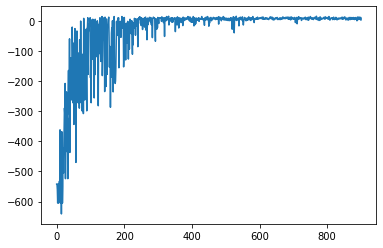

In [0]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    # we are making epsilon smaller 
    agent.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

In [0]:
# render the observations to see how your taxi navigates through the maze
s = env.reset()
for _ in range(30):
    a = agent.get_best_action(s)
        
    next_s, r, done, _ = env.step(a)
    
    s = next_s
    
    env.render()
    
    if done: break

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y